# Load

In [1]:

from function import *
import pandas as pd
import pandas as pd
import geopandas as gpd


abandon_2d_variable = [
    "current_abandonment",
    "recultivation", 
    "abandonment_duration",
    "abandonment_year"
]
fea_3d_variable = [
    'GDPpc',
    'GDPtot',
    'GURdist',
    'Population',
    'gdmp',
    'rsds',
    'tas',
    'wind'
]
fea_2d_variable = [
    'DEM',
    'Powerdist',
    'PrimaryRoad',
    'SecondaryRoad',
    'Slope',
    'TertiaryRoad'
]
PATHS = {
    'abandonment': "D:/xarray/abandonment_chunkall/*.nc",
    'feature':     "D:/xarray/aligned2/Feature_all/*.nc",
    'csv':         "aligned_for_training0519.csv",
    'prediction':  "",
    'prediction_us': "",
    'test_output': "positive_samples_test_500.csv",
    'output':      "positive_samples_full_with_features.csv",
    'CN_sheng': 'data\sheng2022.shp',
    'World_shp':'data\main_ADM_0.shp'
}

YEARS = [2018, 2020]
time=['2018-01-01','2020-01-01']
# 2. 读取 PV 站点并切片（测试模式）
# 2. 读取 PV 站点并切片（测试模式）
# pv_df = load_pv_sites(PATHS['csv'], years=YEARS)
# # Convert lon and lat columns to float32

# pv_df['lon'] = pv_df['lon'].astype('float32')
# pv_df['lat'] = pv_df['lat'].astype('float32')
# # Rename 'year' to 'time' and convert to datetime64
# pv_df = pv_df.rename(columns={'year': 'time'})
# pv_df['time'] = pd.to_datetime(pv_df['time'], format='%Y')




# 1. 打开并 rechunk
ds_abandon, ds_feat = load_datasets(
    PATHS['abandonment'], PATHS['feature']
)

import xarray as xr

ds_merge=xr.merge([ds_abandon, ds_feat])
# Convert coordinates to float32 while preserving other variables
ds_merge = ds_merge.assign_coords({
    'lon': ds_merge.lon.astype('float32'),
    'lat': ds_merge.lat.astype('float32')
})

# For variables without time dimension, expand them to have same value for all times
for var in ds_merge.data_vars:
    if 'time' not in ds_merge[var].dims:
        # Expand the variable to have time dimension with same values
        ds_merge[var] = ds_merge[var].expand_dims(time=ds_merge.time)
ds_merge

# 加载矢量数据

# Read the shapefile
# gdf = gpd.read_file(PATHS['CN_sheng'])
# zj_bound = gdf[gdf['省']=='浙江省']
# zj_bound = zj_bound.to_crs(ds_merge.rio.crs)

gdf = gpd.read_file(PATHS['World_shp'])
us_bound = gdf[gdf['GID_0']=='USA']
us_extent = us_bound.total_bounds  # Returns (minx, miny, maxx, maxy)
us_bound = us_bound.to_crs(ds_merge.rio.crs)



gogogo


c:\Users\zpy10\Anaconda3\envs\glbcropland\Lib\site-packages\dask\array\core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 31
  result = blockwise(
c:\Users\zpy10\Anaconda3\envs\glbcropland\Lib\site-packages\dask\array\core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 31
  result = blockwise(
c:\Users\zpy10\Anaconda3\envs\glbcropland\Lib\site-packages\dask\array\core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 31
  result = blockwise(
c:\Users\zpy10\Anaconda3\envs\glbcropland\Lib\site-packages\dask\array\core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 31
  result = blockwise(
c:\Users\zpy10\Anaconda3\envs\glbcropland\Lib\site-packages\dask\array\core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 124
  result = blockwise(
c:\Users\zpy10\Anaconda3\envs\glbcropland\Lib\site-packages\xarray\core\indexing.py:1598: PerformanceWarning: Slicing is producing a large chunk

In [24]:

# 定义美国研究区

try:
    # 定义东西两部分的边界
    usa_bounds_main = {
        'lon_min': -125,  # 美国本土最西端（华盛顿州）
        'lon_max': -65,   # 美国本土最东端（缅因州）
        'lat_min': 25,    # 美国本土最南端（佛罗里达州）
        'lat_max': 49     # 美国本土最北端（与加拿大接壤）
    }

    usa_bounds_west = {
        'lon_min': 170,   # 阿拉斯加最西端
        'lon_max': 180,   # 日界线西侧
        'lat_min': 18,    # 夏威夷最南端
        'lat_max': 72     # 阿拉斯加最北端
    }

    # 获取东西两部分的mask
    # 创建mask - 选择2020年废弃的栅格
    abandonment_year = ds_merge['abandonment_year'].sel(
        time='2020-01-01',
        lat=slice(usa_bounds_main['lat_min'], usa_bounds_main['lat_max']),
        lon=slice(usa_bounds_main['lon_min'], usa_bounds_main['lon_max'])
    )
    
    abandonment_duration = ds_merge['abandonment_duration'].sel(
        time='2020-01-01', 
        lat=slice(usa_bounds_main['lat_min'], usa_bounds_main['lat_max']),
        lon=slice(usa_bounds_main['lon_min'], usa_bounds_main['lon_max'])
    )
    
    mask_main = ((abandonment_year + abandonment_duration - 2) == 2020)

except:
    None
# Calculate validation number
valid_mask = mask_main.notnull().sum() # Changed notna() to notnull() since it's the correct xarray method
print(f"Number of valid abandonment years: {valid_mask}")


Number of valid abandonment years: <xarray.DataArray ()> Size: 4B
dask.array<sum-aggregate, shape=(), dtype=int32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    time         datetime64[ns] 8B 2020-01-01
    spatial_ref  int32 4B 0
    band         int32 4B 1


In [39]:
ds_merge

<xarray.Dataset> Size: 3TB
Dimensions:               (time: 31, lat: 21600, lon: 43200)
Coordinates:
  * time                  (time) datetime64[ns] 248B 1992-01-01 ... 2022-01-01
    spatial_ref           int32 4B 0
    band                  int32 4B 1
  * lon                   (lon) float32 173kB -180.0 -180.0 ... 180.0 180.0
  * lat                   (lat) float32 86kB -90.0 -89.99 -89.98 ... 89.99 90.0
Data variables: (12/19)
    abandonment_year      (time, lat, lon) float32 116GB dask.array<chunksize=(31, 4600, 2500), meta=np.ndarray>
    abandonment_duration  (time, lat, lon) float32 116GB dask.array<chunksize=(31, 4600, 2500), meta=np.ndarray>
    recultivation         (time, lat, lon) float32 116GB dask.array<chunksize=(31, 4600, 2500), meta=np.ndarray>
    current_abandonment   (time, lat, lon) float32 116GB dask.array<chunksize=(31, 4600, 2500), meta=np.ndarray>
    landcover             (time, lat, lon) float32 116GB dask.array<chunksize=(16, 4350, 2250), meta=np.ndarray>
    DEM                   (time, lat, lon) float32 116GB dask.array<chunksize=(31, 1440, 2880), meta=np.ndarray>
    ...                    ...
    Slope                 (time, lat, lon) float32 116GB dask.array<chunksize=(31, 1440, 2880), meta=np.ndarray>
    TertiaryRoad          (time, lat, lon) float64 231GB dask.array<chunksize=(31, 978, 1964), meta=np.ndarray>
    gdmp                  (time, lat, lon) float64 231GB dask.array<chunksize=(26, 2700, 5400), meta=np.ndarray>
    rsds                  (time, lat, lon) float32 116GB dask.array<chunksize=(26, 3084, 6172), meta=np.ndarray>
    tas                   (time, lat, lon) float64 231GB dask.array<chunksize=(26, 2700, 5400), meta=np.ndarray>
    wind                  (time, lat, lon) float32 116GB dask.array<chunksize=(26, 100, 500), meta=np.ndarray>

# Get data

In [18]:
from tqdm.auto import tqdm
import numpy as np
import os
import pandas as pd 
import geopandas as gpd
import matplotlib.pyplot as plt

def combine_feature(ds_merge, filename , timeflag, step, stop=0):

    #step = 500
    total_lat = len(ds_merge.lat)
    total_lon = len(ds_merge.lon)
    merged_dfs = []
    
    # Calculate total iterations for progress bar
    total_iterations = (total_lat // step + (1 if total_lat % step else 0)) * \
                    (total_lon // step + (1 if total_lon % step else 0))

    # Create progress bar with Chinese description
    pbar = tqdm(total=total_iterations, desc="处理数据块")

    # Iterate through all latitude and longitude points in chunks
    for start_lat in range(0, total_lat, step):
        end_lat = min(start_lat + step, total_lat)
        for start_lon in range(0, total_lon, step):
            end_lon = min(start_lon + step, total_lon)
            #print(1)
            # Extract data from ds_merge for each time point
            df = ds_merge.isel(
                lat=slice(start_lat, end_lat),
                lon=slice(start_lon, end_lon)
            ).compute().to_dataframe()
            
            # Reset index to convert multi-index to columns
            df = df.reset_index()
            merged_dfs.append(df)
            
            # Update progress bar
            pbar.update(1)
            if stop==1:
                break
    # Close progress bar
    pbar.close()

    # Concatenate all chunks
    merged_df = pd.concat(merged_dfs, ignore_index=True)


    # mergedf_path = os.path.join('D:\\xarray\\03_test', f'US_abandonment_{filename}_{timeflag}.csv')
    
    # # Save to CSV
    # merged_df.to_csv(mergedf_path, index=False)
    
    return merged_df



all_vars = list(ds_merge.data_vars)
merged_dfs = []

# Iterate through each variable
for i, var in enumerate(all_vars):
    print(f"Processing variable {i+1} of {len(all_vars)}: {var}")
    
    # Filter for region and time, and apply mask
    df_temp = ds_merge[var].sel(
        time=['2020-01-01'],
        lat=slice(usa_bounds_main['lat_min'], usa_bounds_main['lat_max']),
        lon=slice(usa_bounds_main['lon_min'], usa_bounds_main['lon_max'])
    ).where(mask_main)  
    
    # Process the chunk and merge with pv_df
    merged_df = combine_feature(df_temp, filename=var, timeflag=2020, step=2500, stop=0)
    merged_dfs.append(merged_df)


final_merged_df = merged_dfs[0]
for df in tqdm(merged_dfs[1:], desc="合并数据"):

    final_merged_df = pd.merge(
        final_merged_df,
        df,
        on=["time", "lon", "lat"],
        how="inner",
        suffixes=("", "_drop")
    )
    # Drop duplicated columns with "_drop" suffix
    final_merged_df = final_merged_df.loc[:, ~final_merged_df.columns.str.endswith("_drop")]

# final_merged_df
#df_dem=combine_feature(pv_df, ds_merge.DEM.sel(time=['2018-01-01','2020-01-01']),step=2500,stop=1)
#ds_merge.gdmp.sel(time=['2018-01-01','2020-01-01'])
#df_gdmp=combine_feature(pv_df, ds_merge.gdmp.sel(time=['2018-01-01','2020-01-01']),step=2500,stop=1)


Processing variable 1 of 19: abandonment_year


处理数据块:   0%|          | 0/6 [00:00<?, ?it/s]

Processing variable 2 of 19: abandonment_duration


处理数据块:   0%|          | 0/6 [00:00<?, ?it/s]

Processing variable 3 of 19: recultivation


处理数据块:   0%|          | 0/6 [00:00<?, ?it/s]

Processing variable 4 of 19: current_abandonment


处理数据块:   0%|          | 0/6 [00:00<?, ?it/s]

Processing variable 5 of 19: landcover


处理数据块:   0%|          | 0/6 [00:00<?, ?it/s]

Processing variable 6 of 19: DEM


处理数据块:   0%|          | 0/6 [00:00<?, ?it/s]

Processing variable 7 of 19: GDPpc


处理数据块:   0%|          | 0/6 [00:00<?, ?it/s]

Processing variable 8 of 19: GDPtot


处理数据块:   0%|          | 0/6 [00:00<?, ?it/s]

Processing variable 9 of 19: GURdist


处理数据块:   0%|          | 0/6 [00:00<?, ?it/s]

Processing variable 10 of 19: Population


处理数据块:   0%|          | 0/6 [00:00<?, ?it/s]

Processing variable 11 of 19: Powerdist


处理数据块:   0%|          | 0/6 [00:00<?, ?it/s]

Processing variable 12 of 19: PrimaryRoad


处理数据块:   0%|          | 0/6 [00:00<?, ?it/s]

Processing variable 13 of 19: SecondaryRoad


处理数据块:   0%|          | 0/6 [00:00<?, ?it/s]

Processing variable 14 of 19: Slope


处理数据块:   0%|          | 0/6 [00:00<?, ?it/s]

Processing variable 15 of 19: TertiaryRoad


处理数据块:   0%|          | 0/6 [00:00<?, ?it/s]

Processing variable 16 of 19: gdmp


处理数据块:   0%|          | 0/6 [00:00<?, ?it/s]

Processing variable 17 of 19: rsds


处理数据块:   0%|          | 0/6 [00:00<?, ?it/s]

Processing variable 18 of 19: tas


处理数据块:   0%|          | 0/6 [00:00<?, ?it/s]

Processing variable 19 of 19: wind


处理数据块:   0%|          | 0/6 [00:00<?, ?it/s]

合并数据:   0%|          | 0/18 [00:00<?, ?it/s]

In [19]:
# Count non-NaN values in abandonment_year column
valid_count = final_merged_df['rsds'].notna().sum()
print(f"Number of valid abandonment years: {valid_count}")
# Drop rows where 'rsds' column has NaN values
final_merged_df = final_merged_df.dropna(subset=['rsds'])
print(f"Number of records after dropping NaN rsds values: {len(final_merged_df)}")
final_merged_df

Number of valid abandonment years: 79034
Number of records after dropping NaN rsds values: 79034


,time,lat,lon,spatial_ref,band,abandonment_year,abandonment_duration,recultivation,current_abandonment,landcover,...,Population,Powerdist,PrimaryRoad,SecondaryRoad,Slope,TertiaryRoad,gdmp,rsds,tas,wind
2094,2020-01-01,25.004168,-107.545830,0,1,2018.0,6.0,NaN,1.0,2.0,...,11.311211,622572.6875,9.479545,0.000000,0.922605,44.558012,65.551445,20.555853,2981.984506,1.413225
4586,2020-01-01,25.012501,-107.612503,0,1,2017.0,7.0,NaN,1.0,2.0,...,18.070621,622572.6250,7.480710,0.000000,4.124147,77.081042,76.545799,20.408821,2982.749690,1.381223
4601,2020-01-01,25.012501,-107.487503,0,1,2017.0,7.0,NaN,1.0,2.0,...,30.985685,622572.6875,0.000000,0.000000,2.743563,51.958872,80.134598,20.785990,2980.215050,1.337188
9586,2020-01-01,25.029167,-107.612503,0,1,2017.0,7.0,NaN,1.0,2.0,...,18.070620,622572.6250,7.480710,0.000000,1.319031,77.081042,62.175598,20.607885,2983.972465,1.395731
9850,2020-01-01,25.029167,-105.412498,0,1,2017.0,7.0,NaN,1.0,2.0,...,801.546936,622573.3125,7.372286,0.000000,1.524049,217.405949,104.869400,22.585236,2913.419221,1.931024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20713114,2020-01-01,48.912498,-72.379166,0,1,2018.0,6.0,NaN,1.0,2.0,...,0.601749,622561.2500,10.319467,0.000000,0.145807,27.096933,NaN,12.379357,2751.577779,3.014167
20713117,2020-01-01,48.912498,-72.354164,0,1,2018.0,6.0,NaN,1.0,2.0,...,31.641424,622561.2500,10.319467,0.000000,0.165765,27.096933,NaN,12.358386,2751.663971,3.656837
20726306,2020-01-01,48.962502,-72.445831,0,1,2019.0,5.0,NaN,1.0,2.0,...,0.925847,622561.1875,0.000000,0.000000,0.579822,1.671246,NaN,12.272339,2750.004180,3.908547
20729897,2020-01-01,48.979168,-79.187500,0,1,2008.0,16.0,NaN,1.0,2.0,...,1.477694,622559.0000,0.000000,7.784772,0.470127,31.573702,NaN,12.237657,2738.830619,3.006696


In [14]:
# Save final merged dataframe to CSV
final_merged_df.to_csv('data/us_abandoen.csv', index=False)

In [10]:
df_temp

<xarray.DataArray 'wind' (time: 1, lat: 2880, lon: 7200)> Size: 83MB
dask.array<where, shape=(1, 2880, 7200), dtype=float32, chunksize=(1, 500, 500), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 8B 2020-01-01
    spatial_ref  int32 4B 0
    band         int32 4B 1
  * lon          (lon) float32 29kB -125.0 -125.0 -125.0 ... -65.02 -65.01 -65.0
  * lat          (lat) float32 12kB 25.0 25.01 25.02 25.03 ... 48.98 48.99 49.0

Total number of wind values in df_temp: 20736000 (1 time x 2880 lat x 7200 lon = 20736000)


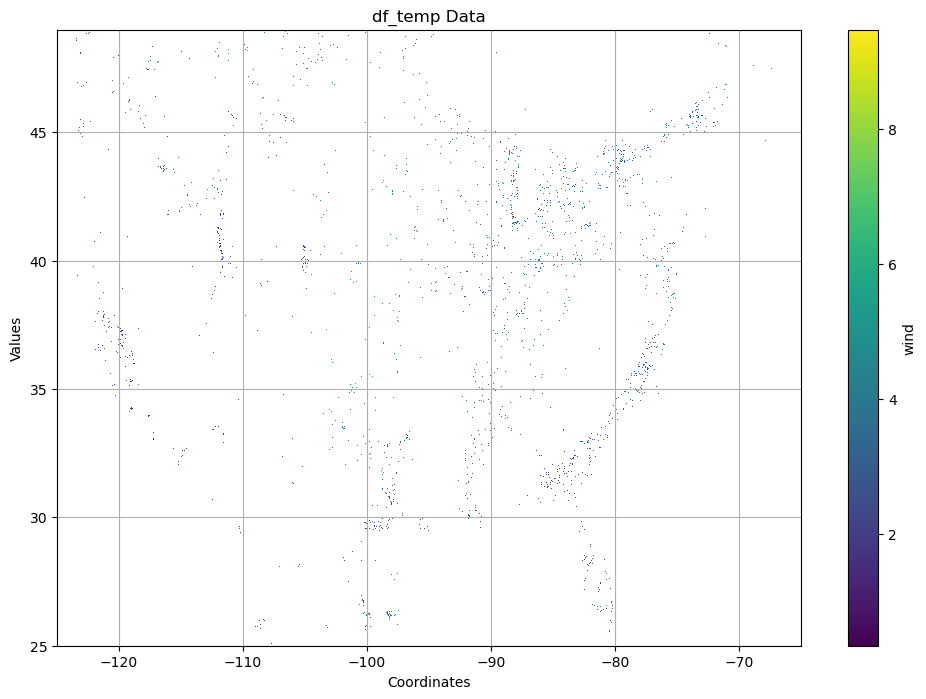

In [11]:
# Plot df_temp using matplotlib
import matplotlib.pyplot as plt
# Count and print number of valid (non-NaN) values in df_temp
valid_count = df_temp.values.ravel().size
print(f"Total number of wind values in df_temp: {valid_count} (1 time x 2880 lat x 7200 lon = {1*2880*7200})")


plt.figure(figsize=(12, 8))
df_temp.plot()
plt.title('df_temp Data')
plt.xlabel('Coordinates')
plt.ylabel('Values')
plt.grid(True)
plt.show()

In [8]:
merged_dfs

[]

纬度：32.5° 到 42.0°（差9.5°）
经度：-124.4° 到 -114.1°（差10.3°）
分辨率：0.0083°
理论格点数：
纬向：9.5° / 0.0083° ≈ 1145点
经向：10.3° / 0.0083° ≈ 1241点

142万差不多

In [9]:

# # Concatenate all merged dataframes with single-column retention
# Read first CSV file
csv_paths = [f'D:\\xarray\\03_training_data\\merged_df_{var}_2020.csv' for var in all_vars]
final_merged_df = pd.read_csv(csv_paths[0])

# Merge remaining CSV files
for csv_path in tqdm(csv_paths[1:], desc="合并数据"):
    df = pd.read_csv(csv_path)
    final_merged_df = pd.merge(
        final_merged_df,
        df,
        on=["time", "lon", "lat"], 
        how="inner",
        suffixes=("", "_drop")
    )
    final_merged_df = final_merged_df.loc[:, ~final_merged_df.columns.str.endswith("_drop")]

合并数据:   0%|          | 0/18 [00:00<?, ?it/s]

In [10]:
final_merged_df

,time,lat,lon,band,spatial_ref,abandonment_year,abandonment_duration,recultivation,current_abandonment,landcover,...,Population,Powerdist,PrimaryRoad,SecondaryRoad,Slope,TertiaryRoad,gdmp,rsds,tas,wind
0,2020-01-01,27.045834,118.02917,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-01,27.045834,118.03750,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-01,27.045834,118.04583,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-01,27.045834,118.05417,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-01,27.045834,118.06250,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293225,2020-01-01,31.179167,122.90417,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
293226,2020-01-01,31.179167,122.91250,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
293227,2020-01-01,31.179167,122.92083,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
293228,2020-01-01,31.179167,122.92917,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


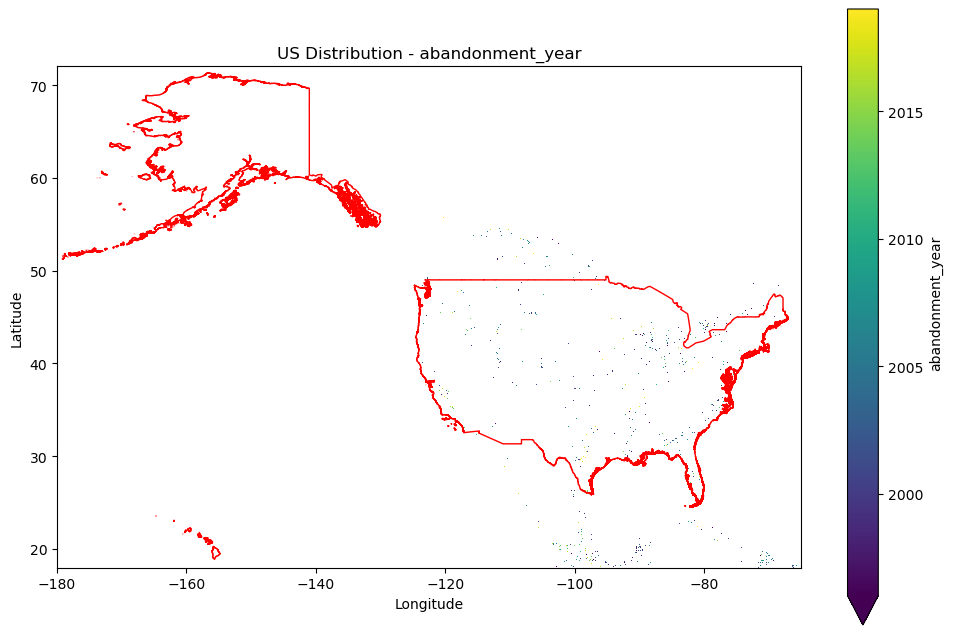

In [ ]:

# Get first variable name
first_var = list(ds_merge.data_vars)[0]

# Create mask for US boundary


ds_us = ds_merge[first_var].sel(
    time='2020-01-01',
    lat=slice(usa_bounds['lat_min'], usa_bounds['lat_max']),
    lon=slice(usa_bounds['lon_min'], usa_bounds['lon_max'])
    )
# Plot masked data
fig, ax = plt.subplots(figsize=(12, 8))
ds_us.plot(
    ax=ax,
    cmap='viridis',
    robust=True,
    add_colorbar=True,
    cbar_kwargs={'label': first_var}
)

# Plot US boundary on top
us_bound.boundary.plot(ax=ax, color='red', linewidth=1)

# Add title and labels
ax.set_title(f'US Distribution - {first_var}')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()



In [15]:
ds_us

<xarray.DataArray 'abandonment_year' (lat: 6480, lon: 13800)> Size: 358MB
dask.array<getitem, shape=(6480, 13800), dtype=float32, chunksize=(500, 2500), chunktype=numpy.ndarray>
Coordinates:
    time         datetime64[ns] 8B 2020-01-01
    spatial_ref  int32 4B 0
    band         int32 4B 1
  * lon          (lon) float32 55kB -180.0 -180.0 -180.0 ... -65.02 -65.01 -65.0
  * lat          (lat) float32 26kB 18.0 18.01 18.02 18.03 ... 71.98 71.99 72.0

# 第三阶段计划

